In [1]:
import pandas as pd
import numpy as np
import ta, ta.trend, ta.momentum
import joblib
import matplotlib.pyplot as plt

def add_ta_features(df, timeframe,rsi_window=14, sma_windows=(5, 20)):
    df = df.copy()
    
    rsi = ta.momentum.RSIIndicator(close=df["close"], window=rsi_window)
    df["rsi_14"] = rsi.rsi()
    
    macd = ta.trend.MACD(close=df["close"])
    df["macd"] = macd.macd()
    df["macd_signal"] = macd.macd_signal()

    sma_short = ta.trend.SMAIndicator(close=df["close"], window=sma_windows[0])
    sma_long = ta.trend.SMAIndicator(close=df["close"], window=sma_windows[1])
    
    df[f"sma_{sma_windows[0]}"] = sma_short.sma_indicator()
    df[f"sma_{sma_windows[1]}"] = sma_long.sma_indicator()

    df["return"] = df["close"].pct_change(periods=timeframe)

    df["future_return"] = df["close"].shift(-1) / df["close"] - 1
    df["target"] = (df["future_return"] > 0).astype(int)
    df = df.dropna()
    return df

def aggregate_and_forwardfill_news(news_df, timeframe='1H'):
    news_df['timestamp'] = pd.to_datetime(news_df['timestamp'])
    numeric_cols = news_df.select_dtypes(include='number').columns.tolist()
    numeric_cols.append('timestamp')
    news_df = news_df[numeric_cols]
    news_df = news_df.set_index('timestamp')
    news_aggregated = news_df.resample(timeframe).mean()
    sentiment_columns = news_aggregated.columns
    news_aggregated[sentiment_columns] = news_aggregated[sentiment_columns].ffill()
    news_aggregated[sentiment_columns] = news_aggregated[sentiment_columns].fillna(0)
    news_aggregated = news_aggregated.reset_index()
    return news_aggregated

def merge_df(df1, df2):
    df1['timestamp'] = pd.to_datetime(df1['timestamp'])
    df2['timestamp'] = pd.to_datetime(df2['timestamp'])

    df1 = df1.set_index('timestamp')
    df2 = df2.set_index('timestamp')

    merged_df = df1.join(df2, how='left')
    merged_df = merged_df.reset_index()
    sentiment_cols = df2.columns
    merged_df[sentiment_cols] = merged_df[sentiment_cols].fillna(0)
    return merged_df

def keep_news(df):
    news_df = df[df['ticker_sentiment'] != 0.0]
    return news_df

In [2]:
btc_hourly = pd.read_csv("./datasets/crypto/hourly/BTC.csv")
btc_4hourly = pd.read_csv("./datasets/crypto/4hourly/BTC.csv")
btc_daily = pd.read_csv("./datasets/crypto/daily/BTC.csv")
btc_weekly = pd.read_csv("./datasets/crypto/weekly/BTC.csv")
btc_news = pd.read_csv("./datasets/crypto/news/BTC_news.csv")


eth_hourly = pd.read_csv("./datasets/crypto/hourly/BTC.csv")
eth_4hourly = pd.read_csv("./datasets/crypto/4hourly/BTC.csv")
eth_daily = pd.read_csv("./datasets/crypto/daily/BTC.csv")
eth_weekly = pd.read_csv("./datasets/crypto/weekly/BTC.csv")
eth_news = pd.read_csv("./datasets/crypto/news/ETH_news.csv")


aapl_hourly = pd.read_csv("./datasets/stocks/hourly/AAPL.csv")
aapl_4hourly = pd.read_csv("./datasets/stocks/4hourly/AAPL.csv")
aapl_daily = pd.read_csv("./datasets/stocks/daily/AAPL.csv")
aapl_weekly = pd.read_csv("./datasets/stocks/weekly/AAPL.csv")
aapl_news = pd.read_csv("./datasets/stocks/news/AAPL_news.csv")


tsla_hourly = pd.read_csv("./datasets/stocks/hourly/TSLA.csv")
tsla_4hourly = pd.read_csv("./datasets/stocks/4hourly/TSLA.csv")
tsla_daily = pd.read_csv("./datasets/stocks/daily/TSLA.csv")
tsla_weekly = pd.read_csv("./datasets/stocks/weekly/TSLA.csv")
tsla_news = pd.read_csv("./datasets/stocks/news/TSLA_news.csv")


amzn_hourly = pd.read_csv("./datasets/stocks/hourly/AMZN.csv")
amzn_4hourly = pd.read_csv("./datasets/stocks/4hourly/AMZN.csv")
amzn_daily = pd.read_csv("./datasets/stocks/daily/AMZN.csv")
amzn_weekly = pd.read_csv("./datasets/stocks/weekly/AMZN.csv")
amzn_news = pd.read_csv("./datasets/stocks/news/AMZN_news.csv")

In [3]:
btc_hourly = add_ta_features(btc_hourly, 1)
btc_4hourly = add_ta_features(btc_4hourly, 4)
btc_daily = add_ta_features(btc_daily, 24)
btc_weekly = add_ta_features(btc_weekly, 168)

btc_news_hourly = aggregate_and_forwardfill_news(btc_news, '1h')
btc_news_4hourly = aggregate_and_forwardfill_news(btc_news, '4h')
btc_news_daily = aggregate_and_forwardfill_news(btc_news, '1d')
btc_news_weekly = aggregate_and_forwardfill_news(btc_news, '1W')

eth_hourly = add_ta_features(eth_hourly, 1)
eth_4hourly = add_ta_features(eth_4hourly, 4)
eth_daily = add_ta_features(eth_daily, 24)
eth_weekly = add_ta_features(eth_weekly, 168)

eth_news_hourly = aggregate_and_forwardfill_news(eth_news, '1h')
eth_news_4hourly = aggregate_and_forwardfill_news(eth_news, '4h')
eth_news_daily = aggregate_and_forwardfill_news(eth_news, '1d')
eth_news_weekly = aggregate_and_forwardfill_news(eth_news, '1W')

aapl_hourly = add_ta_features(aapl_hourly, 1)
aapl_4hourly = add_ta_features(aapl_4hourly, 4)
aapl_daily = add_ta_features(aapl_daily, 24)
aapl_weekly = add_ta_features(aapl_weekly, 120)

aapl_news_hourly = aggregate_and_forwardfill_news(aapl_news, '1h')
aapl_news_4hourly = aggregate_and_forwardfill_news(aapl_news, '4h')
aapl_news_daily = aggregate_and_forwardfill_news(aapl_news, '1d')
aapl_news_weekly = aggregate_and_forwardfill_news(aapl_news, 'W-FRI')

tsla_hourly = add_ta_features(tsla_hourly, 1)
tsla_4hourly = add_ta_features(tsla_4hourly, 4)
tsla_daily = add_ta_features(tsla_daily, 24)
tsla_weekly = add_ta_features(tsla_weekly, 120)

tsla_news_hourly = aggregate_and_forwardfill_news(tsla_news, '1h')
tsla_news_4hourly = aggregate_and_forwardfill_news(tsla_news, '4h')
tsla_news_daily = aggregate_and_forwardfill_news(tsla_news, '1d')
tsla_news_weekly = aggregate_and_forwardfill_news(tsla_news, 'W-FRI')

amzn_hourly = add_ta_features(amzn_hourly, 1)
amzn_4hourly = add_ta_features(amzn_4hourly, 4)
amzn_daily = add_ta_features(amzn_daily, 24)
amzn_weekly = add_ta_features(amzn_weekly, 120)

amzn_news_hourly = aggregate_and_forwardfill_news(amzn_news, '1h')
amzn_news_4hourly = aggregate_and_forwardfill_news(amzn_news, '4h')
amzn_news_daily = aggregate_and_forwardfill_news(amzn_news, '1d')
amzn_news_weekly = aggregate_and_forwardfill_news(amzn_news, 'W-FRI')

In [4]:
merged_btc_hourly = merge_df(btc_hourly, btc_news_hourly)
merged_btc_4hourly = merge_df(btc_4hourly, btc_news_4hourly)
merged_btc_daily = merge_df(btc_daily, btc_news_daily)
merged_btc_weekly = merge_df(btc_weekly, btc_news_weekly)

merged_eth_hourly = merge_df(eth_hourly, eth_news_hourly)
merged_eth_4hourly = merge_df(eth_4hourly, eth_news_4hourly)
merged_eth_daily = merge_df(eth_daily, eth_news_daily)
merged_eth_weekly = merge_df(eth_weekly, eth_news_weekly)

merged_aapl_hourly = merge_df(aapl_hourly, aapl_news_hourly)
merged_aapl_4hourly = merge_df(aapl_4hourly, aapl_news_4hourly)
merged_aapl_daily = merge_df(aapl_daily, aapl_news_daily)
merged_aapl_weekly = merge_df(aapl_weekly, aapl_news_weekly)

merged_tsla_hourly = merge_df(tsla_hourly, tsla_news_hourly)
merged_tsla_4hourly = merge_df(tsla_4hourly, tsla_news_4hourly)
merged_tsla_daily = merge_df(tsla_daily, tsla_news_daily)
merged_tsla_weekly = merge_df(tsla_weekly, tsla_news_weekly)

merged_amzn_hourly = merge_df(amzn_hourly, amzn_news_hourly)
merged_amzn_4hourly = merge_df(amzn_4hourly, amzn_news_4hourly)
merged_amzn_daily = merge_df(amzn_daily, amzn_news_daily)
merged_amzn_weekly = merge_df(amzn_weekly, amzn_news_weekly)

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

FEATURE_COLUMNS = [
    'open', 'high', 'low', 'close', 'volume',
    'rsi_14', 'macd', 'macd_signal',
    'sma_5', 'sma_20', 'return',
    'overall_sentiment_score', 'ticker_sentiment'
]

def train_and_evaluate_logistic_regression(df, target_column='target', model_path=None, scaler_path=None):
    # Step 1: Select Features and Target
    X = df[FEATURE_COLUMNS]
    y = df[target_column]

    # Step 2: Train-Test Split (time-based)
    train_size = int(0.8 * len(df))
    X_train = X.iloc[:train_size]
    X_test = X.iloc[train_size:]
    y_train = y.iloc[:train_size]
    y_test = y.iloc[train_size:]

    # Step 3: Feature Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # ===== Step 4: Train Logistic Regression
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_scaled, y_train)

    if model_path:
        joblib.dump(model, model_path)
    if scaler_path:
        joblib.dump(scaler, scaler_path)

    # ===== Step 5: Predict
    y_pred = model.predict(X_test_scaled)

    # ===== Step 6: Evaluate
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred)
    }

    return metrics

In [6]:
metrics_btc_hourly = train_and_evaluate_logistic_regression(merged_btc_hourly, model_path='models/logisticregression/btc_hourly.pkl', scaler_path='scalers/btc_hourly_scaler.pkl')
metrics_btc_4hourly = train_and_evaluate_logistic_regression(merged_btc_4hourly, model_path='models/logisticregression/btc_4hourly.pkl', scaler_path='scalers/btc_4hourly_scaler.pkl')
metrics_btc_daily = train_and_evaluate_logistic_regression(merged_btc_daily, model_path='models/logisticregression/btc_daily.pkl', scaler_path='scalers/btc_daily_scaler.pkl')
metrics_btc_weekly = train_and_evaluate_logistic_regression(merged_btc_weekly, model_path='models/logisticregression/btc_weekly.pkl', scaler_path='scalers/btc_weekly_scaler.pkl')

metrics_eth_hourly = train_and_evaluate_logistic_regression(merged_eth_hourly, model_path='models/logisticregression/eth_hourly.pkl', scaler_path='scalers/eth_hourly_scaler.pkl')
metrics_eth_4hourly = train_and_evaluate_logistic_regression(merged_eth_4hourly, model_path='models/logisticregression/eth_4hourly.pkl', scaler_path='scalers/eth_4hourly_scaler.pkl')
metrics_eth_daily = train_and_evaluate_logistic_regression(merged_eth_daily, model_path='models/logisticregression/eth_daily.pkl', scaler_path='scalers/eth_daily_scaler.pkl')
metrics_eth_weekly = train_and_evaluate_logistic_regression(merged_eth_weekly, model_path='models/logisticregression/eth_weekly.pkl', scaler_path='scalers/eth_weekly_scaler.pkl')

metrics_aapl_hourly = train_and_evaluate_logistic_regression(merged_aapl_hourly, model_path='models/logisticregression/aapl_hourly.pkl', scaler_path='scalers/aapl_hourly_scaler.pkl')
metrics_aapl_4hourly = train_and_evaluate_logistic_regression(merged_aapl_4hourly, model_path='models/logisticregression/aapl_4hourly.pkl', scaler_path='scalers/aapl_4hourly_scaler.pkl')
metrics_aapl_daily = train_and_evaluate_logistic_regression(merged_aapl_daily, model_path='models/logisticregression/aapl_daily.pkl', scaler_path='scalers/aapl_daily_scaler.pkl')
metrics_aapl_weekly = train_and_evaluate_logistic_regression(merged_aapl_weekly, model_path='models/logisticregression/aapl_weekly.pkl', scaler_path='scalers/aapl_weekly_scaler.pkl')

metrics_tsla_hourly = train_and_evaluate_logistic_regression(merged_tsla_hourly, model_path='models/logisticregression/tsla_hourly.pkl', scaler_path='scalers/tsla_hourly_scaler.pkl')
metrics_tsla_4hourly = train_and_evaluate_logistic_regression(merged_tsla_4hourly, model_path='models/logisticregression/tsla_4hourly.pkl', scaler_path='scalers/tsla_4hourly_scaler.pkl')
metrics_tsla_daily = train_and_evaluate_logistic_regression(merged_tsla_daily, model_path='models/logisticregression/tsla_daily.pkl', scaler_path='scalers/tsla_daily_scaler.pkl')
metrics_tsla_weekly = train_and_evaluate_logistic_regression(merged_tsla_weekly, model_path='models/logisticregression/tsla_weekly.pkl', scaler_path='scalers/tsla_weekly_scaler.pkl')

metrics_amzn_hourly = train_and_evaluate_logistic_regression(merged_amzn_hourly, model_path='models/logisticregression/amzn_hourly.pkl', scaler_path='scalers/amzn_hourly_scaler.pkl')
metrics_amzn_4hourly = train_and_evaluate_logistic_regression(merged_amzn_4hourly, model_path='models/logisticregression/amzn_4hourly.pkl', scaler_path='scalers/amzn_4hourly_scaler.pkl')
metrics_amzn_daily = train_and_evaluate_logistic_regression(merged_amzn_daily, model_path='models/logisticregression/amzn_daily.pkl', scaler_path='scalers/amzn_daily_scaler.pkl')
metrics_amzn_weekly = train_and_evaluate_logistic_regression(merged_amzn_weekly, model_path='models/logisticregression/amzn_weekly.pkl', scaler_path='scalers/amzn_weekly_scaler.pkl')

In [7]:
print(f'BTC Hourly: {metrics_btc_hourly}')
print(f'BTC Weekly: {metrics_btc_4hourly}')
print(f'BTC Weekly: {metrics_btc_daily}')
print(f'BTC Weekly: {metrics_btc_weekly}\n\n')

print(f'ETH Hourly: {metrics_eth_hourly}')
print(f'ETH Weekly: {metrics_eth_4hourly}')
print(f'ETH Weekly: {metrics_eth_daily}')
print(f'ETH Weekly: {metrics_eth_weekly}\n\n')

print(f'AAPL Hourly: {metrics_aapl_hourly}')
print(f'AAPL Weekly: {metrics_aapl_4hourly}')
print(f'AAPL Weekly: {metrics_aapl_daily}')
print(f'AAPL Weekly: {metrics_aapl_weekly}\n\n')

print(f'TSLA Hourly: {metrics_tsla_hourly}')
print(f'TSLA Weekly: {metrics_tsla_4hourly}')
print(f'TSLA Weekly: {metrics_tsla_daily}')
print(f'TSLA Weekly: {metrics_tsla_weekly}\n\n')

print(f'AMZN Hourly: {metrics_amzn_hourly}')
print(f'AMZN Weekly: {metrics_amzn_4hourly}')
print(f'AMZN Weekly: {metrics_amzn_daily}')
print(f'AMZN Weekly: {metrics_amzn_weekly}\n\n')

BTC Hourly: {'accuracy': 0.5282942603071948, 'precision': 0.5211795576658753, 'recall': 0.8330337527461554, 'f1_score': 0.6411990776325903}
BTC Weekly: {'accuracy': 0.511326860841424, 'precision': 0.513555787278415, 'recall': 0.7817460317460317, 'f1_score': 0.6198867212083071}
BTC Weekly: {'accuracy': 0.5257985257985258, 'precision': 0.5, 'recall': 0.27461139896373055, 'f1_score': 0.35451505016722407}
BTC Weekly: {'accuracy': 0.4230769230769231, 'precision': 0.4230769230769231, 'recall': 1.0, 'f1_score': 0.5945945945945946}


ETH Hourly: {'accuracy': 0.5272837510105093, 'precision': 0.5211086872834595, 'recall': 0.811064509686439, 'f1_score': 0.63453125}
ETH Weekly: {'accuracy': 0.5024271844660194, 'precision': 0.5085130533484676, 'recall': 0.7111111111111111, 'f1_score': 0.5929847782925215}
ETH Weekly: {'accuracy': 0.5282555282555282, 'precision': 0.5172413793103449, 'recall': 0.07772020725388601, 'f1_score': 0.13513513513513514}
ETH Weekly: {'accuracy': 0.38461538461538464, 'precisio

In [8]:
# merged_btc_hourly_news = keep_news(merged_btc_hourly)
# merged_btc_4hourly_news = keep_news(merged_btc_4hourly)
# merged_btc_daily_news  = keep_news(merged_btc_daily)
# merged_btc_weekly_news = keep_news(merged_btc_weekly)

# merged_eth_hourly_news  = keep_news(merged_eth_hourly)
# merged_eth_4hourly_news = keep_news(merged_eth_4hourly)
# merged_eth_daily_news = keep_news(merged_eth_daily)
# merged_eth_weekly_news = keep_news(merged_eth_weekly)

# merged_aapl_hourly_news = keep_news(merged_aapl_hourly)
# merged_aapl_4hourly_news = keep_news(merged_aapl_4hourly)
# merged_aapl_daily_news = keep_news(merged_aapl_daily)
# merged_aapl_weekly_news = keep_news(merged_aapl_weekly)

# merged_tsla_hourly_news = keep_news(merged_tsla_hourly)
# merged_tsla_4hourly_news = keep_news(merged_tsla_4hourly)
# merged_tsla_daily_news = keep_news(merged_tsla_daily)
# merged_tsla_weekly_news = keep_news(merged_tsla_weekly)

# merged_amzn_hourly_news = keep_news(merged_amzn_hourly)
# merged_amzn_4hourly_news = keep_news(merged_amzn_4hourly)
# merged_amzn_daily_news = keep_news(merged_amzn_daily)
# merged_amzn_weekly_news = keep_news(merged_amzn_weekly)

In [9]:
# metrics_btc_hourly_news = train_and_evaluate_logistic_regression(merged_btc_hourly_news, model_path='models/btc_hourly_news.pkl', scaler_path='scalers/btc_hourly_news_scaler.pkl')
# metrics_btc_4hourly_news = train_and_evaluate_logistic_regression(merged_btc_4hourly_news, model_path='models/btc_4hourly_news.pkl', scaler_path='scalers/btc_4hourly_news_scaler.pkl')
# metrics_btc_daily_news = train_and_evaluate_logistic_regression(merged_btc_daily_news, model_path='models/btc_daily_news.pkl', scaler_path='scalers/btc_daily_news_scaler.pkl')
# metrics_btc_weekly_news = train_and_evaluate_logistic_regression(merged_btc_weekly_news, model_path='models/btc_weekly_news.pkl', scaler_path='scalers/btc_weekly_news_scaler.pkl')

# metrics_eth_hourly_news = train_and_evaluate_logistic_regression(merged_eth_hourly_news, model_path='models/eth_hourly_news.pkl', scaler_path='scalers/eth_hourly_news_scaler.pkl')
# metrics_eth_4hourly_news = train_and_evaluate_logistic_regression(merged_eth_4hourly_news, model_path='models/eth_4hourly_news.pkl', scaler_path='scalers/eth_4hourly_news_scaler.pkl')
# metrics_eth_daily_news = train_and_evaluate_logistic_regression(merged_eth_daily_news, model_path='models/eth_daily_news.pkl', scaler_path='scalers/eth_daily_news_scaler.pkl')
# metrics_eth_weekly_news = train_and_evaluate_logistic_regression(merged_eth_weekly_news, model_path='models/eth_weekly_news.pkl', scaler_path='scalers/eth_weekly_news_scaler.pkl')

# metrics_aapl_hourly_news = train_and_evaluate_logistic_regression(merged_aapl_hourly_news, model_path='models/aapl_hourly_news.pkl', scaler_path='scalers/aapl_hourly_news_scaler.pkl')
# metrics_aapl_4hourly_news = train_and_evaluate_logistic_regression(merged_aapl_4hourly_news, model_path='models/aapl_4hourly_news.pkl', scaler_path='scalers/aapl_4hourly_news_scaler.pkl')
# metrics_aapl_daily_news = train_and_evaluate_logistic_regression(merged_aapl_daily_news, model_path='models/aapl_daily_news.pkl', scaler_path='scalers/aapl_daily_news_scaler.pkl')
# metrics_aapl_weekly_news = train_and_evaluate_logistic_regression(merged_aapl_weekly_news, model_path='models/aapl_weekly_news.pkl', scaler_path='scalers/aapl_weekly_news_scaler.pkl')

# metrics_tsla_hourly_news = train_and_evaluate_logistic_regression(merged_tsla_hourly_news, model_path='models/tsla_hourly_news.pkl', scaler_path='scalers/tsla_hourly_news_scaler.pkl')
# metrics_tsla_4hourly_news = train_and_evaluate_logistic_regression(merged_tsla_4hourly_news, model_path='models/tsla_4hourly_news.pkl', scaler_path='scalers/tsla_4hourly_news_scaler.pkl')
# metrics_tsla_daily_news = train_and_evaluate_logistic_regression(merged_tsla_daily_news, model_path='models/tsla_daily_news.pkl', scaler_path='scalers/tsla_daily_news_scaler.pkl')
# metrics_tsla_weekly_news = train_and_evaluate_logistic_regression(merged_tsla_weekly_news, model_path='models/tsla_weekly_news.pkl', scaler_path='scalers/tsla_weekly_news_scaler.pkl')

# metrics_amzn_hourly_news = train_and_evaluate_logistic_regression(merged_amzn_hourly_news, model_path='models/amzn_hourly_news.pkl', scaler_path='scalers/amzn_hourly_news_scaler.pkl')
# metrics_amzn_4hourly_news = train_and_evaluate_logistic_regression(merged_amzn_4hourly_news, model_path='models/amzn_4hourly_news.pkl', scaler_path='scalers/amzn_4hourly_news_scaler.pkl')
# metrics_amzn_daily_news = train_and_evaluate_logistic_regression(merged_amzn_daily_news, model_path='models/amzn_daily_news.pkl', scaler_path='scalers/amzn_daily_news_scaler.pkl')
# metrics_amzn_weekly_news = train_and_evaluate_logistic_regression(merged_amzn_weekly_news, model_path='models/amzn_weekly_news.pkl', scaler_path='scalers/amzn_weekly_news_scaler.pkl')

In [10]:
# print(f'BTC Hourly news: {metrics_btc_hourly_news}')
# print(f'BTC Weekly news: {metrics_btc_4hourly_news}')
# print(f'BTC Weekly news: {metrics_btc_daily_news}')
# print(f'BTC Weekly news: {metrics_btc_weekly_news}\n\n')

# print(f'ETH Hourly news: {metrics_eth_hourly_news}')
# print(f'ETH Weekly news: {metrics_eth_4hourly_news}')
# print(f'ETH Weekly news: {metrics_eth_daily_news}')
# print(f'ETH Weekly news: {metrics_eth_weekly_news}\n\n')

# print(f'AAPL Hourly news: {metrics_aapl_hourly_news}')
# print(f'AAPL Weekly news: {metrics_aapl_4hourly_news}')
# print(f'AAPL Weekly news: {metrics_aapl_daily_news}')
# print(f'AAPL Weekly news: {metrics_aapl_weekly_news}\n\n')

# print(f'TSLA Hourly news: {metrics_tsla_hourly_news}')
# print(f'TSLA Weekly news: {metrics_tsla_4hourly_news}')
# print(f'TSLA Weekly news: {metrics_tsla_daily_news}')
# print(f'TSLA Weekly news: {metrics_tsla_weekly_news}\n\n')

# print(f'AMZN Hourly news: {metrics_amzn_hourly_news}')
# print(f'AMZN Weekly news: {metrics_amzn_4hourly_news}')
# print(f'AMZN Weekly news: {metrics_amzn_daily_news}')
# print(f'AMZN Weekly news: {metrics_amzn_weekly_news}\n\n')

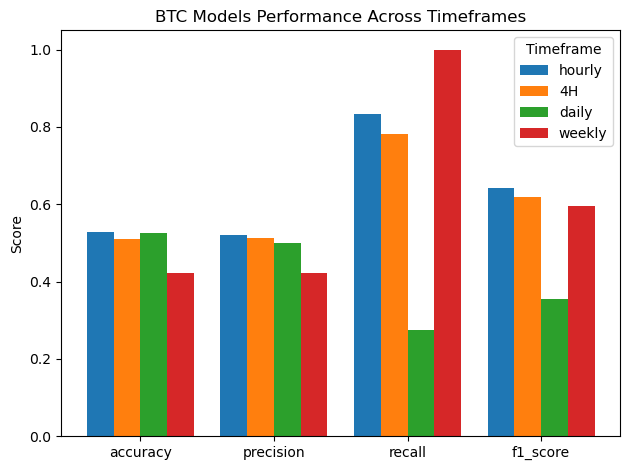

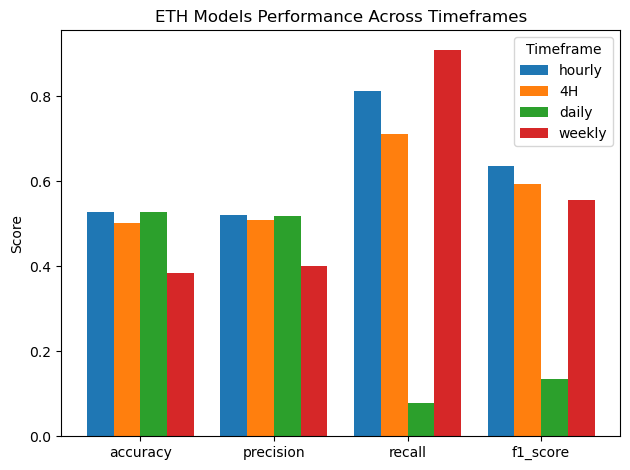

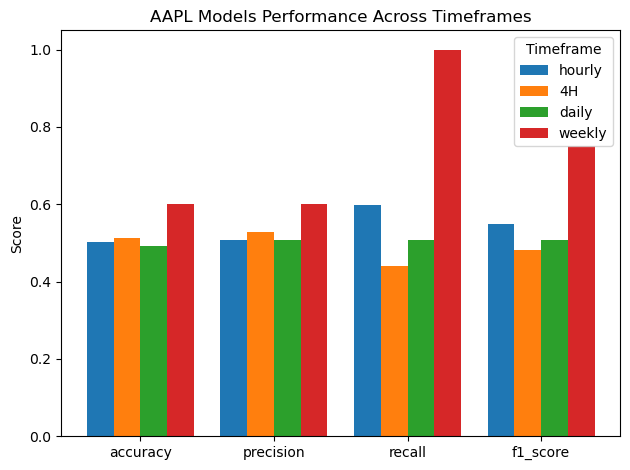

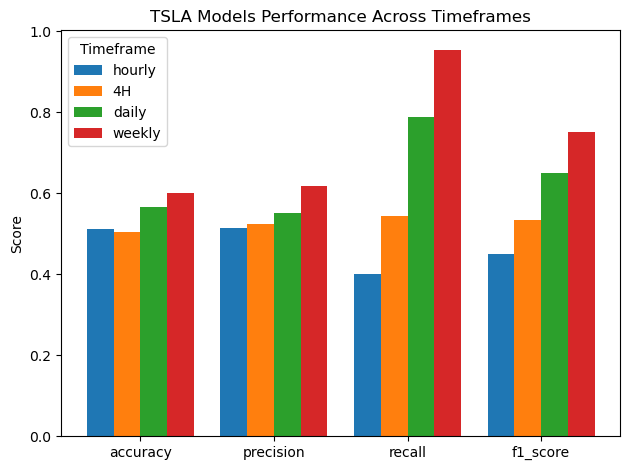

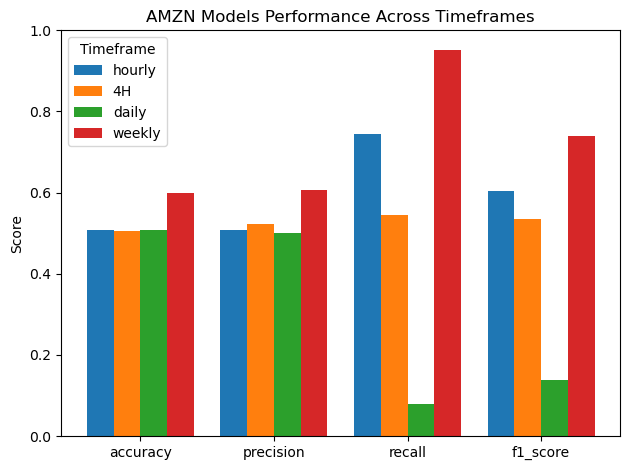

In [11]:
import matplotlib.pyplot as plt

def plot_asset_timeframe_metrics_list(metrics_list, title, timeframes=None):
    if timeframes is None:
        timeframes = ['hourly', '4H', 'daily', 'weekly']
    if len(timeframes) != len(metrics_list):
        raise ValueError("timeframes and metrics_list must have the same length")
    
    metric_names = list(metrics_list[0].keys())
    n_metrics = len(metric_names)
    n_tfs = len(timeframes)
    x = range(n_metrics)
    
    width = 0.8 / n_tfs
    offsets = [(i - n_tfs/2 + 0.5) * width for i in range(n_tfs)]
    
    fig, ax = plt.subplots()
    for idx, (tf_label, metrics) in enumerate(zip(timeframes, metrics_list)):
        vals = [metrics[m] for m in metric_names]
        positions = [pos + offsets[idx] for pos in x]
        ax.bar(positions, vals, width=width, label=tf_label)
    
    ax.set_xticks(x)
    ax.set_xticklabels(metric_names)
    ax.set_ylabel('Score')
    ax.set_title(title)
    ax.legend(title='Timeframe')
    plt.tight_layout()
    plt.show()

plot_asset_timeframe_metrics_list([metrics_btc_hourly, metrics_btc_4hourly, metrics_btc_daily, metrics_btc_weekly], title='BTC Models Performance Across Timeframes')
plot_asset_timeframe_metrics_list([metrics_eth_hourly, metrics_eth_4hourly, metrics_eth_daily, metrics_eth_weekly], title='ETH Models Performance Across Timeframes')
plot_asset_timeframe_metrics_list([metrics_aapl_hourly, metrics_aapl_4hourly, metrics_aapl_daily, metrics_aapl_weekly], title='AAPL Models Performance Across Timeframes')
plot_asset_timeframe_metrics_list([metrics_tsla_hourly, metrics_tsla_4hourly, metrics_tsla_daily, metrics_tsla_weekly], title='TSLA Models Performance Across Timeframes')
plot_asset_timeframe_metrics_list([metrics_amzn_hourly, metrics_amzn_4hourly, metrics_amzn_daily, metrics_amzn_weekly], title='AMZN Models Performance Across Timeframes')

In [12]:
# plot_news_metrics_comparison(metrics_btc_hourly, metrics_btc_hourly_news, 'BTC 1H')
# plot_news_metrics_comparison(metrics_btc_4hourly, metrics_btc_4hourly_news, 'BTC 4H')
# plot_news_metrics_comparison(metrics_btc_daily, metrics_btc_daily_news, 'BTC 1D')
# plot_news_metrics_comparison(metrics_btc_weekly, metrics_btc_weekly_news, 'BTC 1W')

In [13]:
# plot_news_metrics_comparison(metrics_eth_hourly, metrics_eth_hourly_news, 'ETH 1H')
# plot_news_metrics_comparison(metrics_eth_4hourly, metrics_eth_4hourly_news, 'ETH 4H')
# plot_news_metrics_comparison(metrics_eth_daily, metrics_eth_daily_news, 'ETH 1D')
# plot_news_metrics_comparison(metrics_eth_weekly, metrics_eth_weekly_news, 'ETH 1W')

In [14]:
# plot_news_metrics_comparison(metrics_aapl_hourly, metrics_aapl_hourly_news, 'AAPL 1H')
# plot_news_metrics_comparison(metrics_aapl_4hourly, metrics_aapl_4hourly_news, 'AAPL 4H')
# plot_news_metrics_comparison(metrics_aapl_daily, metrics_aapl_daily_news, 'AAPL 1D')
# plot_news_metrics_comparison(metrics_aapl_weekly, metrics_aapl_weekly_news, 'AAPL 1W')

In [15]:
# plot_news_metrics_comparison(metrics_tsla_hourly, metrics_tsla_hourly_news, 'TSLA 1H')
# plot_news_metrics_comparison(metrics_tsla_4hourly, metrics_tsla_4hourly_news, 'TSLA 4H')
# plot_news_metrics_comparison(metrics_tsla_daily, metrics_tsla_daily_news, 'TSLA 1D')
# plot_news_metrics_comparison(metrics_tsla_weekly, metrics_tsla_weekly_news, 'TSLA 1W')

In [16]:
# plot_news_metrics_comparison(metrics_amzn_hourly, metrics_amzn_hourly_news, 'AMZN 1H')
# plot_news_metrics_comparison(metrics_amzn_4hourly, metrics_amzn_4hourly_news, 'AMZN 4H')
# plot_news_metrics_comparison(metrics_amzn_daily, metrics_amzn_daily_news, 'AMZN 1D')
# plot_news_metrics_comparison(metrics_amzn_weekly, metrics_amzn_weekly_news, 'AMZN 1W')

In [17]:
def plot_accuracy_by_timeframe(metrics_list, title, timeframes=None):
    # Default labels
    if timeframes is None:
        timeframes = ['hourly', '4H', 'daily', 'weekly']
    if len(timeframes) != len(metrics_list):
        raise ValueError("timeframes and metrics_list must be the same length")
    
    # Extract accuracy values
    accuracies = [metrics['accuracy'] for metrics in metrics_list]
    
    # Plot
    fig, ax = plt.subplots()
    ax.bar(timeframes, accuracies)
    ax.set_xlabel('Timeframe')
    ax.set_ylabel('Accuracy')
    ax.set_title(f'{title} Model Accuracy by Timeframe')
    ax.set_ylim(0, 1)  # accuracy ranges from 0 to 1
    plt.tight_layout()
    plt.show()


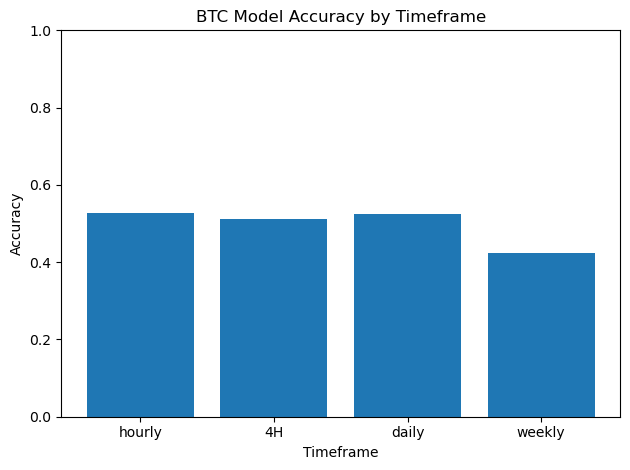

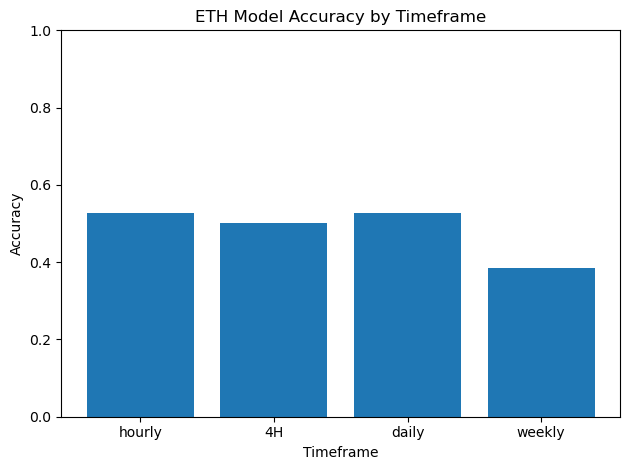

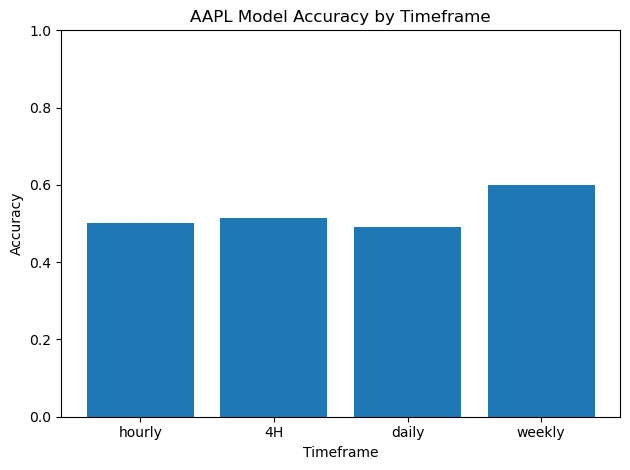

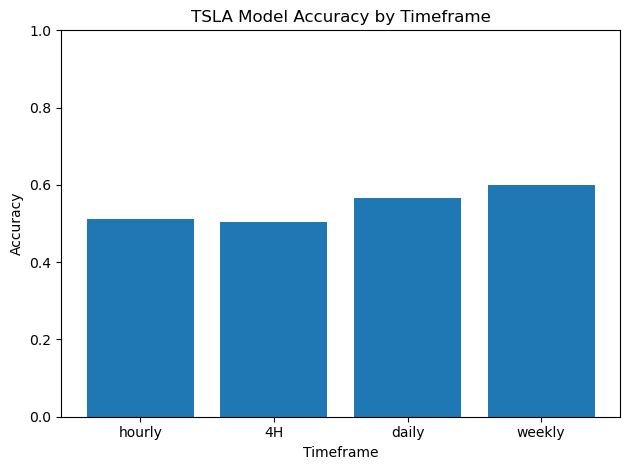

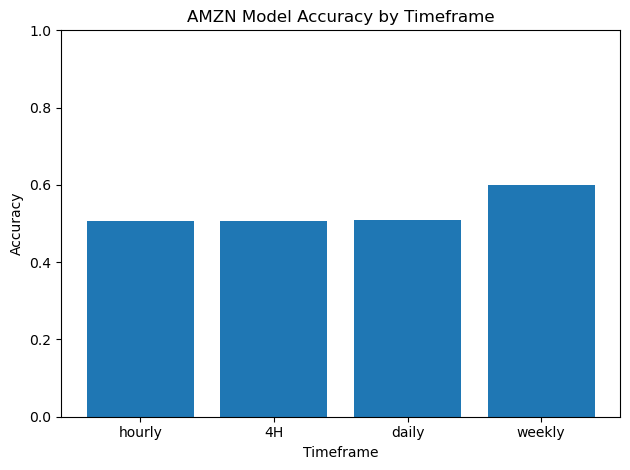

In [18]:
plot_accuracy_by_timeframe([metrics_btc_hourly, metrics_btc_4hourly, metrics_btc_daily, metrics_btc_weekly], 'BTC')
plot_accuracy_by_timeframe([metrics_eth_hourly, metrics_eth_4hourly, metrics_eth_daily, metrics_eth_weekly], 'ETH')
plot_accuracy_by_timeframe([metrics_aapl_hourly, metrics_aapl_4hourly, metrics_aapl_daily, metrics_aapl_weekly], 'AAPL')
plot_accuracy_by_timeframe([metrics_tsla_hourly, metrics_tsla_4hourly, metrics_tsla_daily, metrics_tsla_weekly], 'TSLA')
plot_accuracy_by_timeframe([metrics_amzn_hourly, metrics_amzn_4hourly, metrics_amzn_daily, metrics_amzn_weekly], 'AMZN')